In [2]:
from matplotlib import pyplot as plt 
import numpy as np 
import torch
import pandas
import train_model as tm
import my_models as mm
from torchvision import datasets
import csv

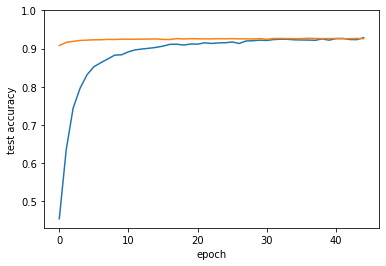

0.926919240201172


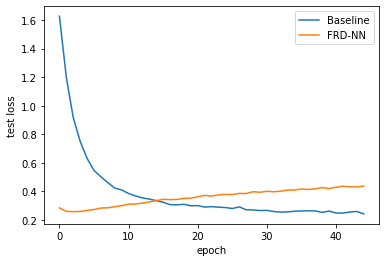

In [6]:
nn_data = pandas.read_csv('/data4/mankovic/FRD-NN/experiments/mnist/raw/rotation_augmentation/raw_triangle_nn_3layer_lr_p01/training_stats.csv')
frd_data = pandas.read_csv('/data4/mankovic/FRD-NN/experiments/mnist/frd/rotation_augmentation/frd_triangle_nn_other4layer_lr_p01/training_stats.csv')
plt.plot(nn_data['Test Accuracy'][:45], label = 'Baseline')
plt.plot(frd_data['Test Accuracy'][:45], label = 'FRD-NN')
plt.yticks([.5,.6,.7,.8,.9,1])
# plt.legend()
plt.ylabel('test accuracy')
plt.xlabel('epoch')
plt.show()

print(np.max(frd_data['Test Accuracy'][:45]))


plt.figure()
plt.plot(nn_data['Test Loss'][:45], label = 'Baseline')
plt.plot(frd_data['Test Loss'][:45], label = 'FRD-NN')
plt.legend()
plt.ylabel('test loss')
plt.xlabel('epoch')
plt.show()

In [3]:
def val_rotations(datapath, model_path, data_transforms):
    model = torch.load(model_path)

    return [tm.test_model(datapath+str(d)+'degrees', model, data_transforms) for d in range(0,360,10)]

frd_accs = val_rotations('/data4/mankovic/FRD-NN/frd_datasets/mnist_splits/', 
                        '/data4/mankovic/FRD-NN/experiments/mnist/frd/frd_triangle_nn_3layer_lastReLU_lr_p01/model/model45.pth',
                        mm.choose_transforms('frd_nn'))
print('frd done')

nn_accs = val_rotations('/data4/mankovic/FRD-NN/raw_datasets/mnist_splits/', 
                        '/data4/mankovic/FRD-NN/experiments/mnist/raw/raw_triangle_nn_3layer_lr_p1/model/model45.pth',
                        mm.choose_transforms('raw_nn'))


print('nn_done')

frd done
nn_done


Text(0, 0.5, 'Test Accuracy')

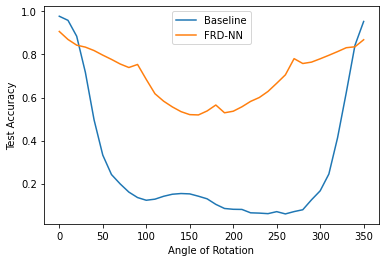

In [4]:
xs = [n for n in range(0,360,10)]


plt.plot(xs, nn_accs, label = 'Baseline')
plt.plot(xs, frd_accs, label ='FRD-NN')
plt.legend()
plt.xlabel('Angle of Rotation')
plt.ylabel('Test Accuracy')

In [2]:
def feat_space_reps(datapath, transformations, model_path = 'no_model'):
    batch_size = 64
   
    feature_space_reps = torch.tensor([])

    if model_path == 'no_model':
        def my_loader(path):
            return torch.load(path)

        image_dataset = {x: datasets.DatasetFolder(os.path.join(datapath, x), loader = my_loader, transform = transformations[x], extensions = '.pt') for x in ['test']}
        dataloaders_dict = {x: torch.utils.data.DataLoader(image_dataset[x], batch_size=batch_size, shuffle=False, num_workers=4) for x in ['test']}


        
        for d,l in dataloaders_dict['test']:
            feature_space_reps = torch.cat([feature_space_reps.float(), d.float()], axis = 0)


    elif 'raw' in model_path:      
        image_dataset = {x: datasets.ImageFolder(os.path.join(datapath, x), transformations[x]) for x in ['test']}
        dataloaders_dict = {x: torch.utils.data.DataLoader(image_dataset[x], batch_size=batch_size, shuffle=False, num_workers=4) for x in ['test']}

        model = torch.load(model_path)         
        modules = list(model.children())[:-2]
        encoder = torch.nn.Sequential(*modules)
        
        encoder.float()

        encoder.eval()   # Set model to evaluate mode

        running_corrects = 0


        for inputs, labels in dataloaders_dict['test']:

            with torch.set_grad_enabled(False):

                outputs = encoder(inputs.float())
                feature_space_reps = torch.cat([feature_space_reps, outputs], axis = 0)

    else:      
        def my_loader(path):
            return torch.load(path)

        image_dataset = {x: datasets.DatasetFolder(os.path.join(datapath, x), loader = my_loader, transform = transformations[x], extensions = '.pt') for x in ['test']}
        dataloaders_dict = {x: torch.utils.data.DataLoader(image_dataset[x], batch_size=batch_size, shuffle=False, num_workers=4) for x in ['test']}

        model = torch.load(model_path)         
        modules = list(model.children())[:-2]
        encoder = torch.nn.Sequential(*modules)
        
        encoder.float()

        encoder.eval()   # Set model to evaluate mode

        running_corrects = 0


        for inputs, labels in dataloaders_dict['test']:

            with torch.set_grad_enabled(False):

                outputs = encoder(inputs.float())
                feature_space_reps = torch.cat([feature_space_reps, outputs], axis = 0)

    return feature_space_reps

In [3]:
def distances(model_path = 'nothing'):
    diff_stats = {'mean':[], 'std': []}
    if 'raw' in model_path:
        transforms = mm.choose_transforms('raw_nn')
        datapath = '/data4/mankovic/FRD-NN/raw_datasets/mnist_splits/0degrees/'

        fs_0 = feat_space_reps(datapath, transforms, model_path)

        
        for d in range(10,360,10):
            datapath = '/data4/mankovic/FRD-NN/raw_datasets/mnist_splits/'+str(d)+'degrees/'
            fs_current = feat_space_reps(datapath, transforms, model_path)
            diffs = torch.norm(fs_0-fs_current, dim = 1)/torch.norm(fs_0, dim=1)
            diff_stats['mean'].append(torch.mean(diffs))
            diff_stats['std'].append(torch.std(diffs))
            print('angle '+str(d)+' done!')

    elif 'frd' in model_path:
        transforms = mm.choose_transforms('frd_nn')
        datapath = '/data4/mankovic/FRD-NN/frd_datasets/mnist_splits/0degrees/'

        fs_0 = feat_space_reps(datapath, transforms, model_path)

        
        for d in range(10,360,10):
            datapath = '/data4/mankovic/FRD-NN/frd_datasets/mnist_splits/'+str(d)+'degrees/'
            fs_current = feat_space_reps(datapath, transforms, model_path)
            diffs = torch.norm(fs_0-fs_current, dim = 1)/torch.norm(fs_0, dim=1)
            diff_stats['mean'].append(torch.mean(diffs))
            diff_stats['std'].append(torch.std(diffs))
            print('angle '+str(d)+' done!')
    else:
        transforms = mm.choose_transforms('frd_nn')
        datapath = '/data4/mankovic/FRD-NN/frd_datasets/mnist_splits/0degrees/'

        fs_0 = feat_space_reps(datapath, transforms, 'no_model')

        
        for d in range(10,360,10):
            datapath = '/data4/mankovic/FRD-NN/frd_datasets/mnist_splits/'+str(d)+'degrees/'
            fs_current = feat_space_reps(datapath, transforms)
            diffs = torch.norm(fs_0-fs_current, dim = 1)/torch.norm(fs_0, dim=1)
            diff_stats['mean'].append(torch.mean(diffs))
            diff_stats['std'].append(torch.std(diffs))
            print('angle '+str(d)+' done!')
    return diff_stats

In [4]:
model_path = '/data4/mankovic/FRD-NN/experiments/mnist/raw/raw_triangle_nn_3layer_lr_p1/model/model49.pth'
raw_stats = distances(model_path)





angle 10 done!
angle 20 done!
angle 30 done!
angle 40 done!
angle 50 done!
angle 60 done!
angle 70 done!
angle 80 done!
angle 90 done!
angle 100 done!
angle 110 done!
angle 120 done!
angle 130 done!
angle 140 done!
angle 150 done!
angle 160 done!
angle 170 done!
angle 180 done!
angle 190 done!
angle 200 done!
angle 210 done!
angle 220 done!
angle 230 done!
angle 240 done!
angle 250 done!
angle 260 done!
angle 270 done!
angle 280 done!
angle 290 done!
angle 300 done!
angle 310 done!
angle 320 done!
angle 330 done!
angle 340 done!
angle 350 done!


In [5]:
frd_stats = distances()

angle 10 done!
angle 20 done!
angle 30 done!
angle 40 done!
angle 50 done!
angle 60 done!
angle 70 done!
angle 80 done!
angle 90 done!
angle 100 done!
angle 110 done!
angle 120 done!
angle 130 done!
angle 140 done!
angle 150 done!
angle 160 done!
angle 170 done!
angle 180 done!
angle 190 done!
angle 200 done!
angle 210 done!
angle 220 done!
angle 230 done!
angle 240 done!
angle 250 done!
angle 260 done!
angle 270 done!
angle 280 done!
angle 290 done!
angle 300 done!
angle 310 done!
angle 320 done!
angle 330 done!
angle 340 done!
angle 350 done!


In [6]:
model_path = '/data4/mankovic/FRD-NN/experiments/mnist/frd/frd_triangle_nn_3layer_lastReLU_lr_p01/model/model45.pth'
frd_nn_stats = distances(model_path)

angle 10 done!
angle 20 done!
angle 30 done!
angle 40 done!
angle 50 done!
angle 60 done!
angle 70 done!
angle 80 done!
angle 90 done!
angle 100 done!
angle 110 done!
angle 120 done!
angle 130 done!
angle 140 done!
angle 150 done!
angle 160 done!
angle 170 done!
angle 180 done!
angle 190 done!
angle 200 done!
angle 210 done!
angle 220 done!
angle 230 done!
angle 240 done!
angle 250 done!
angle 260 done!
angle 270 done!
angle 280 done!
angle 290 done!
angle 300 done!
angle 310 done!
angle 320 done!
angle 330 done!
angle 340 done!
angle 350 done!


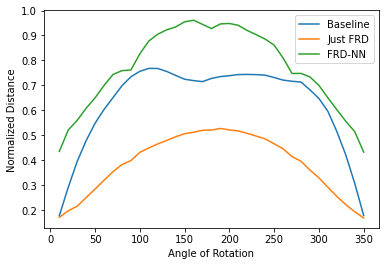

In [23]:
xs= [n for n in range(10,360,10)]
plt.plot(xs, raw_stats['mean'], label = 'Baseline')
plt.plot(xs, frd_stats['mean'], label = 'Just FRD')
plt.plot(xs, frd_nn_stats['mean'], label = 'FRD-NN')
plt.xlabel('Angle of Rotation')
plt.ylabel('Normalized Distance')
plt.legend()
plt.show()

In [21]:
def make_csv(csv_filename, datadict):
    with open(csv_file, 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['mean','std'])
        for data in zip(datadict['mean'], datadict['std']):
            writer.writerow([data[0].item(), data[1].item()])

In [26]:
csv_filename = '/data4/mankovic/FRD-NN/experiments/mnist/raw/raw_triangle_nn_3layer_lr_p1/distances.csv'
make_csv(csv_filename, raw_stats)

csv_filename = './frd_distances.csv'
make_csv(csv_filename, frd_stats)

csv_filename = '/data4/mankovic/FRD-NN/experiments/mnist/frd/frd_triangle_nn_3layer_lastReLU_lr_p01/distances.csv'
make_csv(csv_filename, frd_nn_stats)

In [14]:
raw_stats['mean']

[tensor(0.1767),
 tensor(0.2907),
 tensor(0.3948),
 tensor(0.4780),
 tensor(0.5481),
 tensor(0.6031),
 tensor(0.6506),
 tensor(0.6982),
 tensor(0.7342),
 tensor(0.7561),
 tensor(0.7679),
 tensor(0.7674),
 tensor(0.7556),
 tensor(0.7397),
 tensor(0.7244),
 tensor(0.7189),
 tensor(0.7147),
 tensor(0.7276),
 tensor(0.7350),
 tensor(0.7385),
 tensor(0.7432),
 tensor(0.7436),
 tensor(0.7429),
 tensor(0.7406),
 tensor(0.7312),
 tensor(0.7209),
 tensor(0.7163),
 tensor(0.7132),
 tensor(0.6818),
 tensor(0.6475),
 tensor(0.5959),
 tensor(0.5151),
 tensor(0.4211),
 tensor(0.3071),
 tensor(0.1781)]